This notebook uses DEM elevations to make a mask for LS.

This notebook was created on 1-20-23. Edited 3-21-23.

***

Import things. Use conda environment oliviaJupyter.

In [2]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

Load the DEM and crop it to small unwrapped region.

In [4]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'

# size of full res SLCs (same as DEM)
dxIN=18000
dyIN=3600

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(0,0,dxIN,dyIN)
box = np.zeros((5,2))
x1 = 17000; x2 = 14000; 
y1 = 1750;  y2 = 1000;  

# larger region with western mtns.
x1 = 18000
y1 = 2100

dx = x1-x2
dy = y1-y2
box[0] = [x1,y1]; box[1] = [x2,y1]
box[2] = [x2,y2]; box[3] = [x1,y2]; box[4] = box[0]
elev_cropped = elev[y2:y1,x2:x1]

print('DEM loaded + cropped.')

DEM loaded + cropped.


Mask it based on being below certain elevation. 

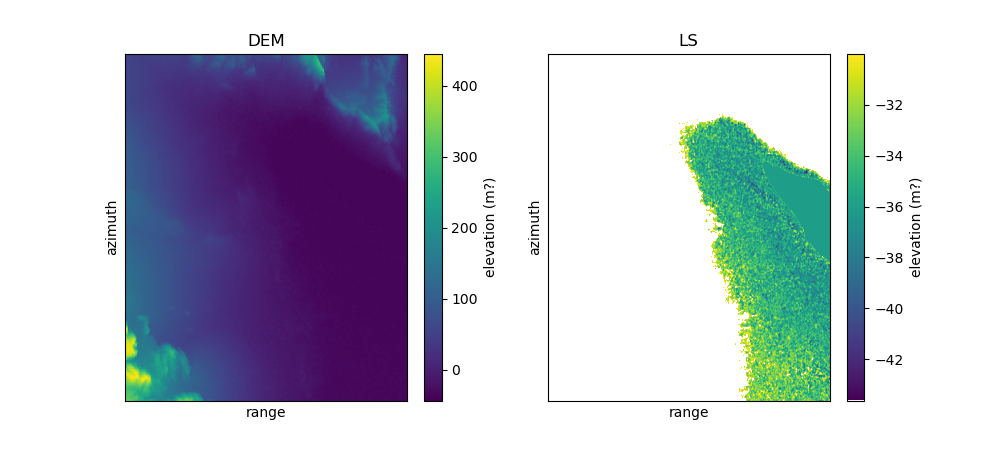

In [5]:
elev_masked_LS = np.ma.masked_where(elev_cropped>-30,elev_cropped)

plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(elev_cropped, cmap='viridis',interpolation='nearest',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('DEM'); plt.colorbar(label='elevation (m?)')
plt.subplot(1,2,2)
plt.imshow(elev_masked_LS, cmap='viridis',interpolation='nearest',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('LS'); plt.colorbar(label='elevation (m?)')
plt.show()

Now make array to be saved as the LS mask.

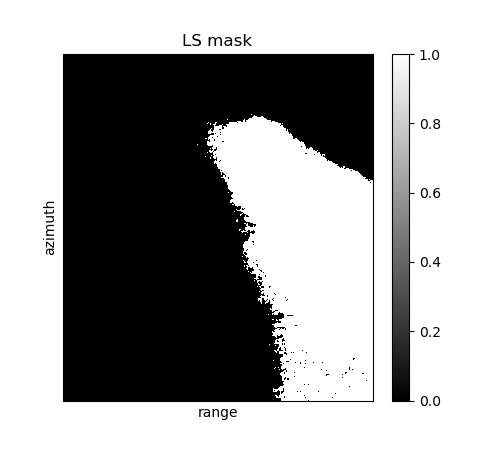

In [6]:
mask_y,mask_x = np.nonzero(elev_masked_LS)
LS_mask = np.zeros((dy,dx))
LS_mask[mask_y,mask_x] = 1.0

# plot it to make sure it matches plot above.
plt.figure(figsize=(5,4.5))
plt.imshow(LS_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('LS mask') 
plt.colorbar(); plt.show()

In [8]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# set the folder to save this mask file to
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/'
save_file_name = 'LS_mask.r4'

colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(LS_mask)
colds=None
print('Mask of Laguna Salada saved.')

Mask of Laguna Salada.


Now make a mask for just the UNSTABLE portion of LS. There is a really stable portion on the east side that we don't want to take into account because it behaves differently than the rest of LS. 

In [9]:
# load in coherence of sequential igrams 
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
coh = np.ndarray((numIgrams,dy,dx),dtype='float')
for i in range(numIgrams): #range(numIgrams)
    date1=dates[i]
    date2=dates[i+1]
    file_name = 'coh_'+str(date1)+'-'+str(date2)+'.r4' # CHECK FOR - or _ in names
    f1 = gdal.Open(saveDir+file_name, gdal.GA_ReadOnly)
    coh[i] = f1.ReadAsArray()
f1 = None
print('Coh maps loaded.')


Coh maps loaded.


In [10]:
# initialize arrays for means and stds
coh_mean = np.ndarray((dy,dx),dtype='float')
for y in range(dy):         # dy
    for x in range(dx):     # dx
        coh_temp = coh[:,y,x]
        coh_mean[y,x] = np.median(coh_temp)
print('Coh mean calculated for each pixel.')

Coh mean calculated for each pixel.


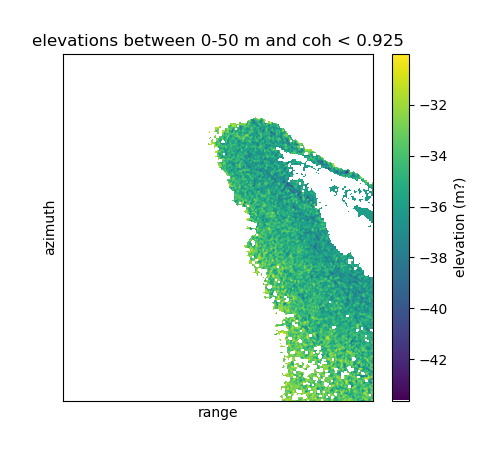

In [29]:
th_coh_mean = 0.925
elev_and_coh_masked = np.ma.masked_where(coh_mean>th_coh_mean,elev_masked_LS)
plt.figure(figsize=(5,4.5))
plt.imshow(elev_and_coh_masked, cmap='viridis',aspect='auto'); plt.xlim(x1-x2,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('elevations between 0-50 m and coh < '+str(th_coh_mean)); plt.colorbar(label='elevation (m?)')
plt.show()

In [30]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# set the folder to save this mask file to
#saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/'
save_file_name = 'LS_stable_portion_removed_mask.r4'

colds = driver.Create(saveDir+save_file_name,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(LS_mask)
colds=None
print('Mask of Laguna Salada with stable portion removed saved.')

Mask of Laguna Salada with stable portion removed saved.
